<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/FinRL-test

Mounted at /content/gdrive/
/content/gdrive/My Drive/FinRL-test


<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [10]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install gymnasium
!pip install stable-baselines3
!pip install stockstats
!pip install alpaca-trade-api
!pip install exchange-calendars
!pip install pyfolio
# -------------------------------------
# IF YOU CHOOSE TO GO THIS ROUTE, UNCOMMENT from finrl.meta.preprocessor.yahoodownloader import YahooDownloader BELOW

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pwd

/content/gdrive/My Drive/FinRL-test


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import importlib

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor import fixed_yahoodownloader # comment this if you chose other path above
importlib.reload(fixed_yahoodownloader) # comment this if you chose other path above
from finrl.meta.preprocessor.fixed_yahoodownloader import YahooDownloader #comment this if you chose the other path above

# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader - uncomment this if you chose the other path above

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.agents.stablebaselines3.a2c_model import DRLA2CAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [5]:
# TRAIN_START_DATE = '2009-04-01'
# TRAIN_END_DATE = '2021-01-01'
# TEST_START_DATE = '2021-01-01'
# TEST_END_DATE = '2022-06-01'
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.config_tickers import DOW_30_TICKER

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2023-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GS']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[************

Shape of DataFrame:  (93702, 8)
Display DataFrame:           date      close       high        low       open    volume  tic  day
0  2010-01-04  32.906170  41.099998  40.389999  40.810001   6894300  AXP    0
1  2010-01-05  32.833801  41.230000  40.369999  40.830002  10641200  AXP    1
2  2010-01-06  33.364548  41.669998  41.169998  41.230000   8399400  AXP    2
3  2010-01-07  33.905674  42.240002  41.110001  41.259998   8981700  AXP    3
4  2010-01-08  33.881454  42.480000  41.400002  41.759998   7907700  AXP    4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [6]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [7]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [8]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 28, State Space: 169


In [9]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

<a id='5'></a>
# Part 6: A2C with standard hyperparameters

In [10]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

In [11]:
agent = DRLA2CAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [12]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }
df_summary = agent.run_A2C_strategy(A2C_model_kwargs, 10000)

============Start A2C2 Strategy============
turbulence_threshold:  198.79036393731144
======Model training from:  2010-01-01 to  2021-10-04
======A2C2 Training========
Using cuda device
Logging to tensorboard_log/A2C\A2C2_126_2
--------------------------------------
| time/                 |            |
|    fps                | 66         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | 0.0348     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -46.2      |
|    reward             | -0.2157504 |
|    std                | 1          |
|    value_loss         | 2.04       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 200     

In [13]:
df_summary

,Iter,Val Start,Val End,A2C Sharpe
0,126,2021-10-04,2022-01-03,0.166632
1,189,2022-01-03,2022-04-04,-0.236885
2,252,2022-04-04,2022-07-06,-0.273787
3,315,2022-07-06,2022-10-04,-0.237964


In [14]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [15]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('A2C2',i))
    df_account_value = pd.concat([df_account_value, temp], axis=0, ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.5794264915525301


In [16]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.000739e+06,2022-01-04,0.000739,2022-01-04
2,9.991548e+05,2022-01-05,-0.001583,2022-01-05
3,9.963206e+05,2022-01-06,-0.002837,2022-01-06
4,9.951673e+05,2022-01-07,-0.001158,2022-01-07


In [17]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.129653
Cumulative returns    -0.129653
Annual volatility      0.204548
Sharpe ratio          -0.579426
Calmar ratio          -0.488325
Stability              0.461262
Max drawdown          -0.265506
Omega ratio            0.908354
Sortino ratio         -0.802406
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936716
Daily value at risk   -0.026241
dtype: float64


In [18]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (251, 8)
Annual return         -0.088436
Cumulative returns    -0.088101
Annual volatility      0.185081
Sharpe ratio          -0.410029
Calmar ratio          -0.407645
Stability              0.243620
Max drawdown          -0.216945
Omega ratio            0.935511
Sortino ratio         -0.568133
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.966671
Daily value at risk   -0.023619
dtype: float64


In [19]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.008656e+06
2    2022-01-05  1.011041e+06
3    2022-01-06  1.002408e+06
4    2022-01-07  9.980177e+05
..          ...           ...
247  2022-12-27  9.147240e+05
248  2022-12-28  9.158399e+05
249  2022-12-29  9.091405e+05
250  2022-12-30  9.118987e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.008656e+06
2022-01-05  1.011041e+06
2022-01-06  1.002408e+06
2022-01-07  9.980177e+05
...                  ...
2022-12-27  9.147240e+05
2022-12-28  9.158399e+05
2022-12-29  9.091405e+05
2022-12-30  9.118987e+05
2023-01-03           NaN

[252 rows x 1 columns]


In [ ]:
df.to_csv("df.csv")
df_result_a2c = pd.DataFrame({'date': df_account_value['date'], 'A2C2': df_account_value['account_value']})
df_result_a2c = df_result_a2c.set_index('date')

print("df_result_ensemble.columns: ", df_result_a2c.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_a2c.to_csv("df_result_a2c_no_opt.csv")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_a2c, df_dji, left_index=True, right_index=True)
result.to_csv("result.csv")
result.columns = ['A2C', 'dji']

# Part 7: A2C with optimized hyperparameters

In [21]:
agent = DRLA2CAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [22]:
A2C_model_kwargs = {
    'learning_rate': 0.0720661604820144, 
    'n_steps': 2048, 
    'ent_coef': 4.009097084190781e-05
    }
df_summary = agent.run_A2C_strategy(A2C_model_kwargs, 10000)

============Start A2C2 Strategy============
turbulence_threshold:  198.79036393731144
======Model training from:  2010-01-01 to  2021-10-04
======A2C2 Training========
Using cuda device
Logging to tensorboard_log/A2C\A2C2_126_3
======A2C2 Validation from:  2021-10-04 to  2022-01-03
A2C2 Sharpe Ratio:  0.44715948534147665
======Best Model Retraining from:  2010-01-01 to  2022-01-03
======Trading from:  2022-01-03 to  2022-04-04
turbulence_threshold:  198.79036393731144
======Model training from:  2010-01-01 to  2022-01-03
======A2C2 Training========
Using cuda device
Logging to tensorboard_log/A2C\A2C2_189_3
======A2C2 Validation from:  2022-01-03 to  2022-04-04
A2C2 Sharpe Ratio:  -0.10120299597696385
======Best Model Retraining from:  2010-01-01 to  2022-04-04
======Trading from:  2022-04-04 to  2022-07-06
turbulence_threshold:  198.79036393731144
======Model training from:  2010-01-01 to  2022-04-04
======A2C2 Training========
Using cuda device
Logging to tensorboard_log/A2C\A2C2_252

In [23]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [24]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('A2C2',i))
    df_account_value = pd.concat([df_account_value, temp], axis=0, ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.07800412468580224


In [25]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-01-03,NaN,2022-01-03
1,1.001008e+06,2022-01-04,0.001008,2022-01-04
2,9.972771e+05,2022-01-05,-0.003727,2022-01-05
3,9.954757e+05,2022-01-06,-0.001806,2022-01-06
4,9.967951e+05,2022-01-07,0.001325,2022-01-07


In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.032223
Cumulative returns    -0.032223
Annual volatility      0.190270
Sharpe ratio          -0.078004
Calmar ratio          -0.187991
Stability              0.000635
Max drawdown          -0.171408
Omega ratio            0.986857
Sortino ratio         -0.110072
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.121621
Daily value at risk   -0.024031
dtype: float64


In [27]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (251, 8)
Annual return         -0.088436
Cumulative returns    -0.088101
Annual volatility      0.185081
Sharpe ratio          -0.410029
Calmar ratio          -0.407645
Stability              0.243620
Max drawdown          -0.216945
Omega ratio            0.935511
Sortino ratio         -0.568133
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.966671
Daily value at risk   -0.023619
dtype: float64


In [28]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


df_dji:             date           dji
0    2022-01-03  1.000000e+06
1    2022-01-04  1.008656e+06
2    2022-01-05  1.011041e+06
3    2022-01-06  1.002408e+06
4    2022-01-07  9.980177e+05
..          ...           ...
247  2022-12-27  9.147240e+05
248  2022-12-28  9.158399e+05
249  2022-12-29  9.091405e+05
250  2022-12-30  9.118987e+05
251  2023-01-03           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.008656e+06
2022-01-05  1.011041e+06
2022-01-06  1.002408e+06
2022-01-07  9.980177e+05
...                  ...
2022-12-27  9.147240e+05
2022-12-28  9.158399e+05
2022-12-29  9.091405e+05
2022-12-30  9.118987e+05
2023-01-03           NaN

[252 rows x 1 columns]


In [30]:
print(df_account_value)

     account_value        date  daily_return    datadate
0     1.000000e+06  2022-01-03           NaN  2022-01-03
1     1.001008e+06  2022-01-04      0.001008  2022-01-04
2     9.972771e+05  2022-01-05     -0.003727  2022-01-05
3     9.954757e+05  2022-01-06     -0.001806  2022-01-06
4     9.967951e+05  2022-01-07      0.001325  2022-01-07
..             ...         ...           ...         ...
247   9.820228e+05  2022-12-27      0.004282  2022-12-27
248   9.695423e+05  2022-12-28     -0.012709  2022-12-28
249   9.780291e+05  2022-12-29      0.008753  2022-12-29
250   9.749500e+05  2022-12-30     -0.003148  2022-12-30
251   9.677768e+05  2023-01-03     -0.007358  2023-01-03

[252 rows x 4 columns]


In [32]:
df.to_csv("df.csv")
df_result_a2c_2 = pd.DataFrame({'date': df_account_value['date'], 'A2C_Optimized': df_account_value['account_value']})
df_result_a2c_2 = df_result_a2c_2.set_index('date')

print("df_result_ensemble.columns: ", df_result_a2c_2.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
df_result_a2c_2.to_csv("df_result_a2c_opt.csv")

df_result_ensemble.columns:  Index(['A2C_Optimized'], dtype='object')


In [33]:
df_result = pd.read_csv('result.csv')

df_merged = pd.merge(
    df_result,
    df_result_a2c_2,
    on='date',
    how='left'  # Use 'left' to keep all dates from 'df_result'
)

df_merged.to_csv('result_a2c_compare.csv', index=False)

In [39]:
print(df_merged.head())

         date          A2C2           dji  A2C_Optimized
0  2022-01-03  1.000000e+06  1.000000e+06   1.000000e+06
1  2022-01-04  1.000739e+06  1.008656e+06   1.001008e+06
2  2022-01-05  9.991548e+05  1.011041e+06   9.972771e+05
3  2022-01-06  9.963206e+05  1.002408e+06   9.954757e+05
4  2022-01-07  9.951673e+05  9.980177e+05   9.967951e+05


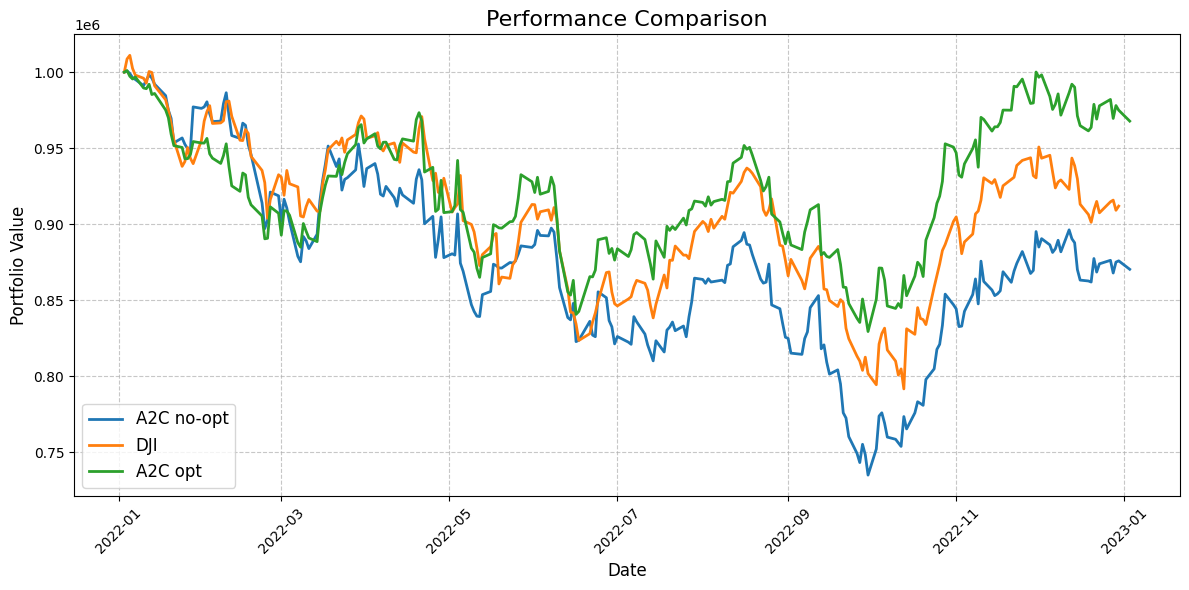

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('result_a2c_compare.csv')  # Replace 'data.csv' with your actual file name

# Convert the 'date' column to datetime format for better x-axis representation
df['date'] = pd.to_datetime(df['date'])

# Plotting
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot each column
plt.plot(df['date'], df['A2C2'], label='A2C no-opt', linewidth=2)
plt.plot(df['date'], df['dji'], label='DJI', linewidth=2)
plt.plot(df['date'], df['A2C_Optimized'], label='A2C opt', linewidth=2)

# Add title and labels
plt.title('Performance Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
%matplotlib inline
plt.show()